In this notebook we show an example of how to use Chromatix to propagate through a birefringent material using the multi-slice method from multislice computational model for birefringent scattering, https://doi.org/10.1364/OPTICA.472077.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import Array

import chromatix.functional as cf
from chromatix.utils.utils import sigmoid_taper

%config InlineBackend.figure_format='retina'

Let's make the same sample as the authors in figure 2.

In [2]:
# Getting a sample
def Rx(theta: Array) -> Array:
    """
    Rotation matrix around x-axis for z-y-x vector order.
    :param theta: Angle of rotation in radians
    :return: 3x3 rotation matrix
    """
    return jnp.array(
        [
            [jnp.cos(theta), jnp.sin(theta), 0],
            [-jnp.sin(theta), jnp.cos(theta), 0],
            [0, 0, 1],
        ]
    )


def Ry(theta: Array) -> Array:
    """
    Rotation matrix around y-axis for z-y-x vector order.
    :param theta: Angle of rotation in radians
    :return: 3x3 rotation matrix
    """
    return jnp.array(
        [
            [jnp.cos(theta), 0, -jnp.sin(theta)],
            [0, 1, 0],
            [jnp.sin(theta), 0, jnp.cos(theta)],
        ]
    )


def Rz(theta: Array) -> Array:
    """
    Rotation matrix around z-axis for z-y-x vector order.
    :param theta: Angle of rotation in radians
    :return: 3x3 rotation matrix
    """
    return jnp.array(
        [
            [1, 0, 0],
            [0, jnp.cos(theta), jnp.sin(theta)],
            [0, -jnp.sin(theta), jnp.cos(theta)],
        ]
    )


def R(theta_z, theta_y, theta_x):
    return Rz(theta_z) @ Ry(theta_y) @ Rx(theta_x)


def paper_sample() -> Array:
    # Calculating shape
    shape = np.around((np.array(size) / spacing)).astype(
        int
    )  # without around becomes 1 less!

    # center of pixel is our coordinate
    z = jnp.linspace(1 / 2 * spacing, size[0] - 1 / 2 * spacing, shape[0])
    y = jnp.linspace(size[1] - 1 / 2 * spacing, 1 / 2 * spacing, shape[1])
    x = jnp.linspace(1 / 2 * spacing, size[2] - 1 / 2 * spacing, shape[2])
    grid = jnp.stack(jnp.meshgrid(z, y, x, indexing="ij"), axis=-1)

    # Position of each bead, with radius
    bead_pos = jnp.array(
        [
            [size[0] / 2, 8.85, 2.85],
            [size[0] / 2, 8.85, 8.85],
            [size[0] / 2, 2.85, 2.85],
            [size[0] / 2, 2.85, 8.85],
        ]
    )
    rotation = jnp.array(
        [
            [0.0, jnp.pi / 2, 0.0],
            [0.0, 0.0, 0.0],
            [0.0, 0.0, jnp.pi / 2],
            [jnp.pi / 4, jnp.pi / 4, jnp.pi / 4],
        ]
    )

    permitivitty = jnp.zeros((*shape, 3, 3))

    # Adding each bead
    for pos, orientation in zip(bead_pos, rotation):
        # Making bead and background
        bead_permitivitty = R(*orientation).T @ jnp.diag(n_bead**2) @ R(*orientation)
        background_permitivitty = jnp.eye(3) * n_background**2

        # Mask
        mask = jnp.sum((grid - pos) ** 2, axis=-1) < bead_radius**2

        # Making sample
        permitivitty += k0**2 * jnp.where(
            mask[..., None, None],
            background_permitivitty - bead_permitivitty,
            jnp.zeros((3, 3)),
        )

    return permitivitty


# Simulation settings
size = (4.55, 11.7, 11.7)  # from paper
spacing = 0.065  # [mum], from paper
wavelength = 0.405  # [mum], from paper
n_background = 1.33
n_bead = jnp.array([1.44, 1.40, 1.37])  # z y x
polarization = cf.linear(0)  # x-polarized light
k0 = 2 * jnp.pi / wavelength
bead_radius = 1.5  # [mum]
NA = 0.8

potential = paper_sample()

In [3]:
print(f"Sample shape: {potential.shape}")

Sample shape: (70, 180, 180, 3, 3)


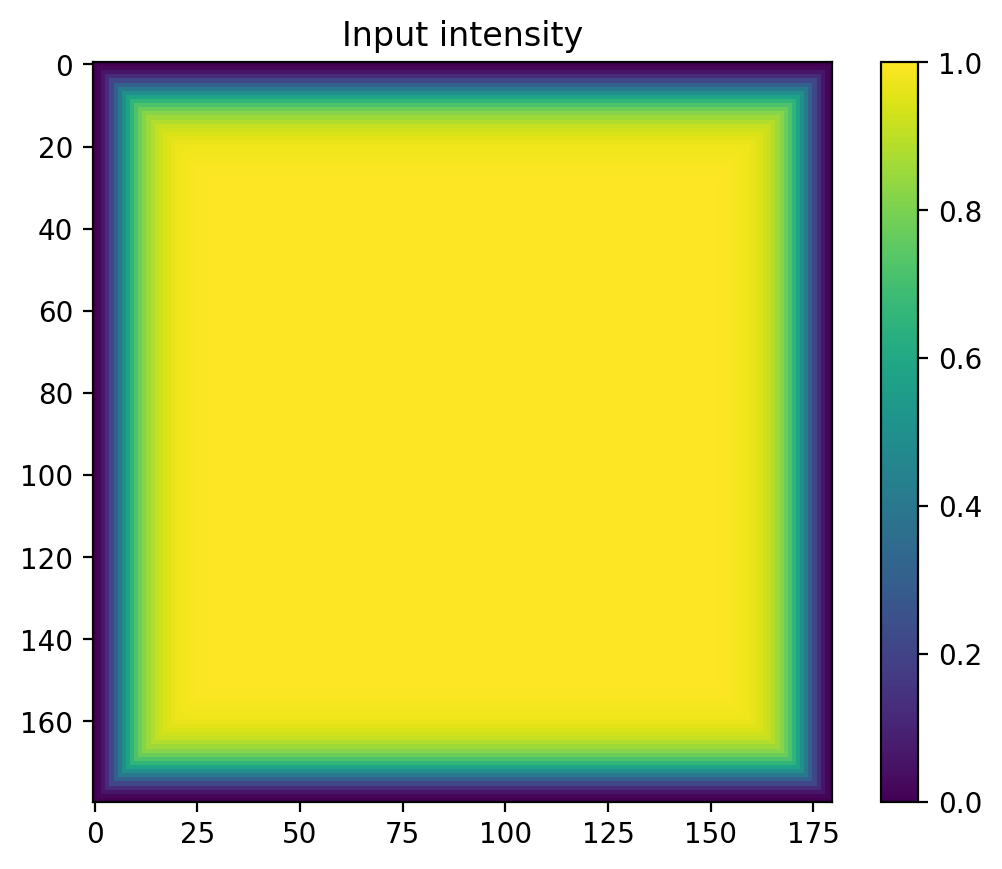

In [4]:
# Making the field
field = cf.plane_wave(
    (potential.shape[1], potential.shape[2]),
    spacing,
    wavelength,
    amplitude=polarization,
    scalar=False,
)

# Making sure the amplitude = [0, 0, 1]
field = field.replace(u=field.u / field.u[90, 90, 2])

# Adding a little apodisation
field = field.replace(
    u=field.u * sigmoid_taper(field.spatial_shape, 4)[..., jnp.newaxis]
)

plt.title("Input intensity")
plt.imshow(field.intensity.squeeze())
plt.colorbar()
plt.show()

After we've constructed the sample and the incoming field, just call `polarized_multislice_thick_sample`:

In [5]:
out_field = cf.polarized_multislice_thick_sample(
    field, potential, n_background, spacing, NA=NA
)
amplitude = out_field.amplitude
phase = out_field.phase

Note that our results don't entirely match those from the paper (particularly the lower right bead), as the authors had bug in their code (personal correspondence).

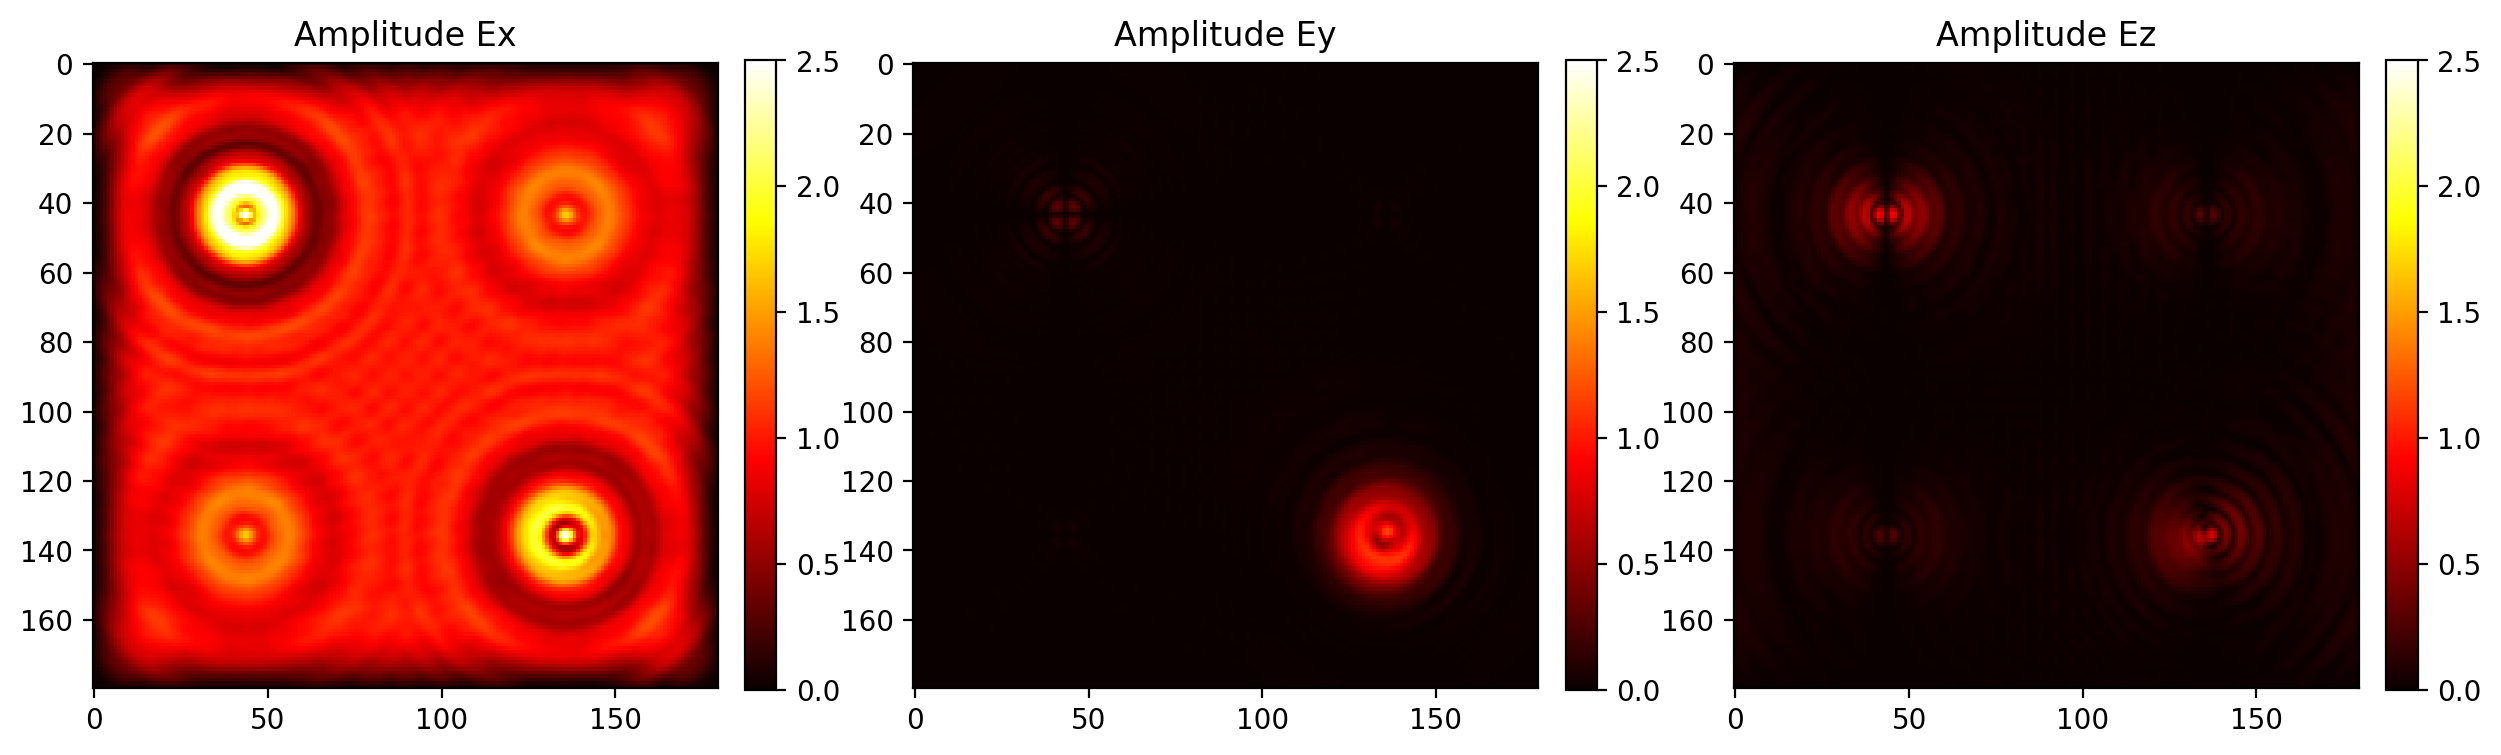

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Amplitude Ex")
plt.imshow(amplitude[..., 2], cmap="hot", vmin=0.0, vmax=2.5)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Amplitude Ey")
plt.imshow(amplitude[..., 1], cmap="hot", vmin=0.0, vmax=2.5)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Amplitude Ez")
plt.imshow(amplitude[..., 0], cmap="hot", vmin=0.0, vmax=2.5)
plt.colorbar(fraction=0.046, pad=0.04)

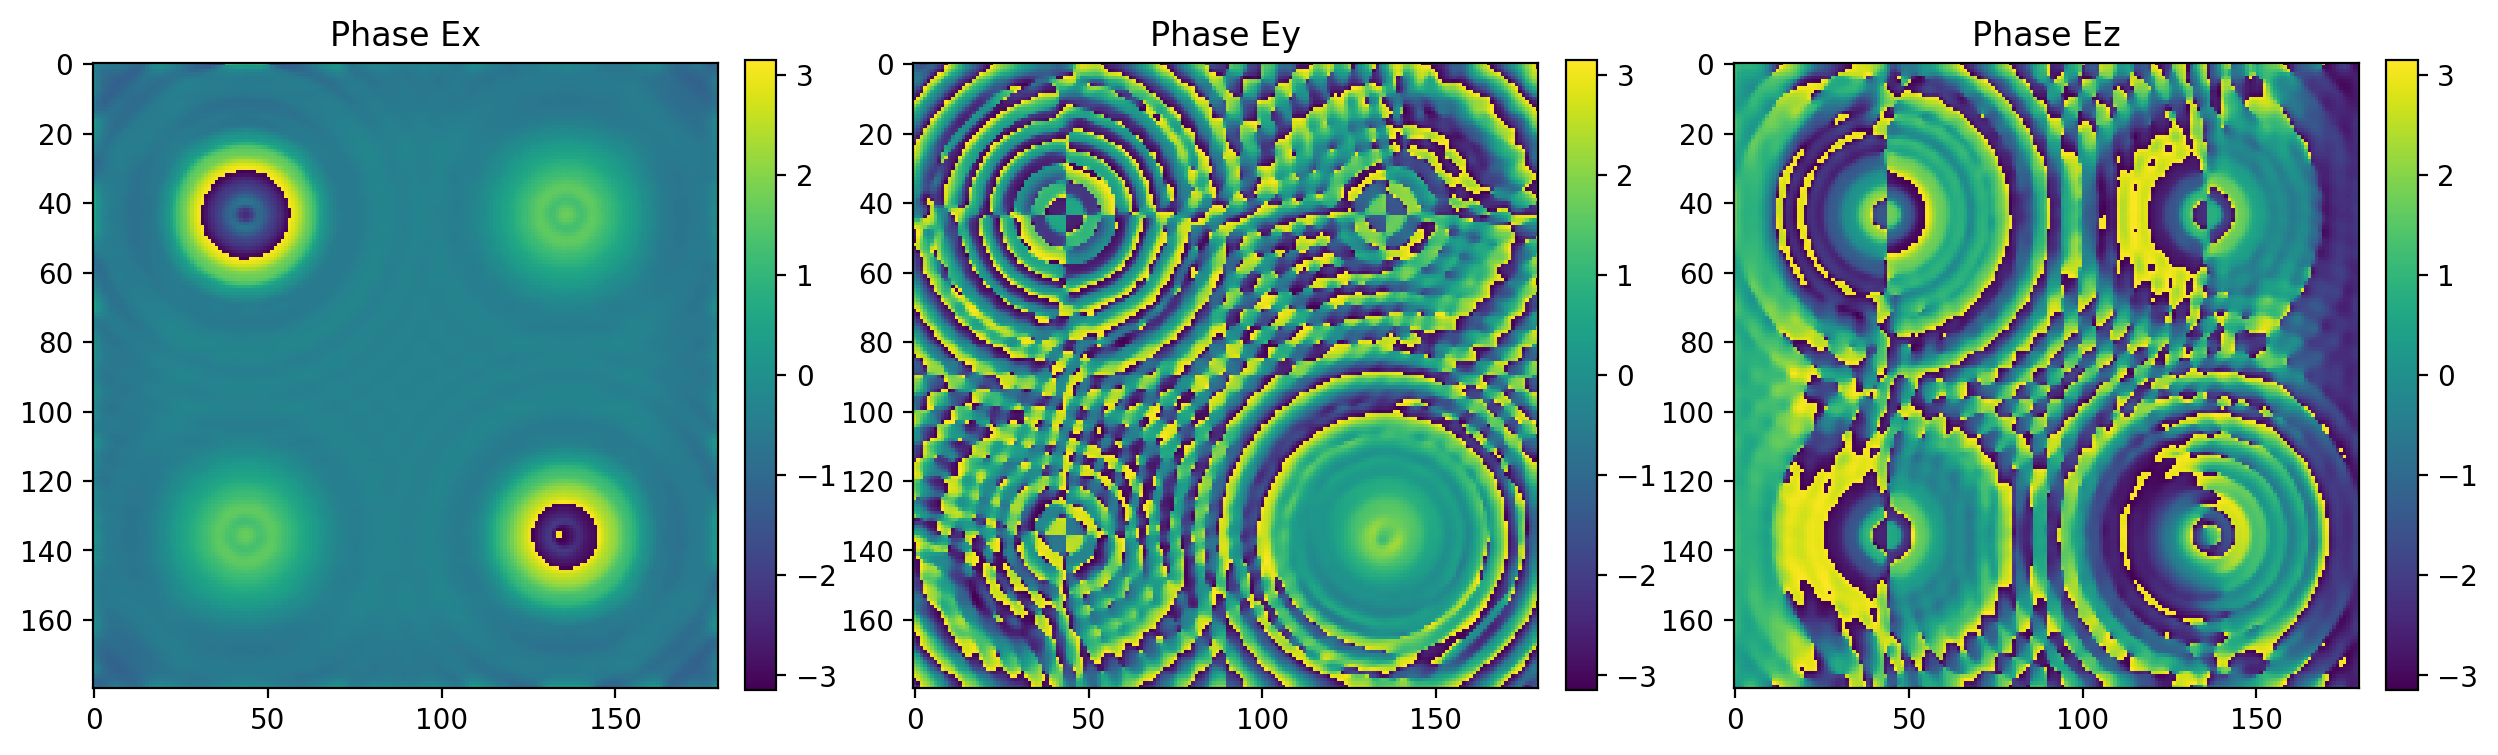

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Phase Ex")
plt.imshow(phase[..., 2], vmin=-jnp.pi, vmax=jnp.pi)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Phase Ey")
plt.imshow(phase[..., 1], vmin=-jnp.pi, vmax=jnp.pi)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Phase Ez")
plt.imshow(phase[..., 0], vmin=-jnp.pi, vmax=jnp.pi)
plt.colorbar(fraction=0.046, pad=0.04)